In [1]:
from __future__ import print_function, division
import os
import torch
import random 
from torch.utils import data
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import random;
import math;

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Initialise dataset class

In [2]:
class PlanktonDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels, transform=None):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        
        # Select sample
        ID = self.list_IDs[index]
        
        img_name = os.path.join('train_images/',ID)
        X = io.imread(img_name)
        
        if self.transform:
            X = self.transform(X)
        
        y = self.labels[ID]

        return X, y

# Preprocessing classes
These classes should return the image object

In [3]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        h, w = image.shape
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return img
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return image
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = np.expand_dims(image, axis=0)
        return torch.from_numpy(image)

# Create training and validation sets

In [67]:
# Parameters
num_epochs = 38;
batch_size = 32;
learning_rate = 0.001;

resize_scale = 100
crop = 32

num_classes = pd.read_csv('label_map.txt').shape[0]

In [68]:
# Collect image info
training_data = pd.read_csv('train_onelabel.csv')

# Partitions containing image names
IDs = training_data['image'].tolist()
random.shuffle(IDs)

slicing = int(len(IDs)/7)

partition = {}
partition['train'] = IDs[:slicing]
partition['validation'] = IDs[slicing:]

# Labels of trained images  
labels = dict(zip(training_data['image'], training_data['class']))

In [69]:
# Generators
training_set = PlanktonDataset(partition['train'], 
                               labels, 
                               transform=transforms.Compose([Rescale(resize_scale),RandomCrop(crop),ToTensor()]))
training_generator = data.DataLoader(dataset=training_set,
                                           batch_size=batch_size,
                                           shuffle=True)

validation_set = PlanktonDataset(partition['validation'], 
                               labels, 
                               transform=transforms.Compose([Rescale(resize_scale),RandomCrop(crop),ToTensor()]))
validation_generator = data.DataLoader(dataset=validation_set,
                                           batch_size=batch_size,
                                           shuffle=True)

# Testing if everything worked so far

torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])


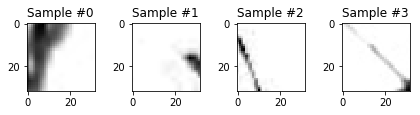

In [70]:
fig = plt.figure()

for i in range(len(training_set)):
    
    sample = training_set[i]
    print(sample[0].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    plt.imshow(sample[0][0,:,:],cmap='gray')

    if i == 3:
        plt.show()
        break 

----

In [71]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(8*8*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        #print('1', out.shape)
        out = self.layer2(out)
        #print('2', out.shape)
        out = out.view(out.size(0), -1)
        #print('3', out.shape)
        out = self.fc(out)
        #print('4', out.shape)
        return out

In [72]:
#instance of the Conv Net
cnn = CNN();
#loss function and optimizer
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);

In [ ]:
losses = [];
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(training_generator):
        images = Variable(images.float())
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        #loss = criterion(outputs, labels)
        #loss.backward()
        #optimizer.step()
        
        #losses.append(loss.data[0]);
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d' %(epoch+1, num_epochs, i+1, len(training_generator)//batch_size))
            
            

Epoch : 1/38, Iter : 100/3
Epoch : 2/38, Iter : 100/3
Epoch : 3/38, Iter : 100/3
Epoch : 4/38, Iter : 100/3
Epoch : 5/38, Iter : 100/3
Epoch : 6/38, Iter : 100/3
Epoch : 7/38, Iter : 100/3
Epoch : 8/38, Iter : 100/3
Epoch : 9/38, Iter : 100/3
Epoch : 10/38, Iter : 100/3
Epoch : 11/38, Iter : 100/3
Epoch : 12/38, Iter : 100/3
Epoch : 13/38, Iter : 100/3


In [ ]:
outputs

In [77]:
criterion?

In [76]:
nn.LogSoftmax?

In [ ]:
m = nn.LogSoftmax()
    >>> input = torch.randn(2, 3)
    >>> output = m(input)

In [78]:
nn.NLLLoss?